In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
import torch.cuda as cuda
from torch.autograd import Variable
import math

from utils import create_dataloader,train
from dataset import EEG
import wandb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os
import sys


sys.path.append(os.path.abspath(os.path.join('..')))
# Now do your import
from config import *

In [2]:
from model import ConvNet,CNN2D,ConvNet2
from torchsummary import summary
net = ConvNet2()
online_path = "/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/Training/save_weight/S21_CNN_iir_LHRF_4ch/0.6584_S21_CNN_iir_LHRF_4ch_0.6584_66.6667.pth"
net.load_state_dict(torch.load(online_path))

<All keys matched successfully>

In [3]:
# home directory + datasets folder
path = RECORED_PATH
#subject to run
left_runs = [4,6,8,10,12]
right_runs = [3,5,7,9,11]
subjects = [17]
#recorded eeg class
left_eeg = EEG(path, subjects, left_runs)
raw=left_eeg.data_to_raw()
right_eeg = EEG(path, subjects, right_runs)
right_raw = right_eeg.data_to_raw()

print("Raw done")
data, sf = raw.get_data(), raw.info['sfreq']

raw = left_eeg.pickChannel(raw,['T3','C3','C4','T4','STIM MARKERS'])
right_raw = right_eeg.pickChannel(right_raw,['T3','C3','C4','T4','STIM MARKERS'])

X_l,y_l = left_eeg.raw_preprocess(raw,event_id=[1.0],rest_stage=False)
#print(X_l.shape,y_l.shape)
X_r,y_r = right_eeg.raw_preprocess(right_raw,event_id=[2.0],rest_stage=False)
X = np.concatenate((X_l,X_r),axis=0)
y = np.concatenate((y_l,y_r),axis=0)
print(X.shape,y.shape)

print(X.shape)
print(X[0,0,:])
print(y)

X = left_eeg.apply_baseline(X)

/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/dataset/recorded_EEG
/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/dataset/recorded_EEG
Raw done
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[817, 5503, 10190, 14883, 19569, 24258, 28944, 33628, 38317, 43004, 47668, 52357, 57046, 61734, 66420, 71111, 75797, 80480, 85171, 89857, 94521, 99204, 103893, 108579, 113266, 117953, 122640, 127323, 132009, 136697, 141356, 146043, 150727, 155416, 160100, 164786, 169473, 174161, 178845, 183533, 188195, 192879, 197560, 202244, 206925, 211616, 216305, 220988, 225674, 230361]


/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/Training/dataset.py:67: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in an error because the following channel names are missing:
['T3', 'T4']
Either fix your included names or explicitly pass ordered=False.
  self.raw = raw.pick_channels(channel)
/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/Training/dataset.py:67: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in an error because the following channel names are missing:
['T3', 'T4']
Either fix your included names or explicitly pass ordered=False.
  self.raw = raw.pick_channels(channel)


[3159, 7845, 12531, 17214, 21901, 26587, 31278, 35967, 40653, 45336, 49997, 54681, 59367, 64050, 68739, 73425, 78105, 82791, 87475, 92161, 96824, 101508, 106189, 110873, 115559, 120243, 124931, 129617, 134303, 138987, 143660, 148347, 153037, 157726, 162413, 167100, 171785, 176470, 181157, 185841, 190504, 195190, 199875, 204560, 209243, 213929, 218611, 223299, 227985, 232671]
(100, 2, 1750) (100,)
(100, 2, 1750)
[  4.41850245   4.2665647    4.18982971 ... -13.47327096 -12.51375206
 -11.52214162]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [4]:
batch_size = 1750
test_loader = create_dataloader(X, y, batch_size=batch_size)

num_step =math.ceil(len(test_loader.dataset) / batch_size)

In [5]:
# Train the model
num_epochs = 1

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):

    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(0)
            classes = classes.cuda(0)
        
        outputs = net(items)
        #loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        
        for i in range(predicted.shape[0]):
            
            if predicted[i] == classes.data[i]:
                correct += 1
            
        #correct += (predicted == classes.data).sum()
        
        iterations += 1

    #valid_loss.append(loss/iterations)
    #correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct / len(test_loader.dataset) * 100.0)
print (' Val Acc: %.4f'
                   %(valid_accuracy[-1]))

RuntimeError: Given groups=1, weight of size [32, 4, 10], expected input[100, 2, 1750] to have 4 channels, but got 2 channels instead

In [ ]:
print(predicted)
print(classes.data.cpu().numpy())
y_true = classes.data.cpu().numpy()
y_pred = y_pred=predicted.cpu().numpy()

tensor([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0])
[1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0
 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1
 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1]


In [ ]:
confusion_matrix(y_true, y_pred)

array([[21, 29],
       [21, 29]])

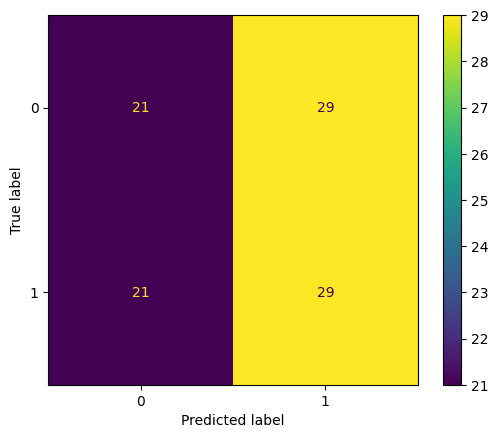

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)